
# Projet 3 — Modélisation : Prédiction du Churn Client

Ce notebook implémente plusieurs modèles de classification (Régression Logistique, Arbre de Décision, Random Forest) —
évalue leurs performances, procède à une optimisation d'hyperparamètres (GridSearchCV / RandomizedSearchCV) et sauvegarde
les meilleurs artefacts (modèles, préprocesseur).

**Pré-requis** : exécuter le notebook `Churn_EDA_Preparation.ipynb`. Ce notebook contient un pipeline complet qui reproduit le préprocessing.


## 1) Imports et chargement des données

In [ ]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
pd.set_option("display.max_columns", 200)

# chemins
sample_path = Path("C:/Users/mckll/Desktop/projet3_churn_repo/telco_sample.csv")
main_path = Path("telco_sample.csv")
DATA_PATH = main_path if main_path.exists() else sample_path
print("DATA_PATH:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
df.shape, df.head(2)

'''
Importe et charge les données de la DatBase pour pouvoir les utiliser
'''


DATA_PATH: telco_sample.csv


## 2) Nettoyage 

In [ ]:

# Reproduire les mêmes étapes que dans le notebook EDA/Preparation
df = df.copy()
if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)
service_cols = ["MultipleLines","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
for c in service_cols:
    if c in df.columns:
        df[c] = df[c].replace({"No internet service":"No", "No phone service":"No"})
df["Churn"] = df["Churn"].map({"Yes":1, "No":0}).astype(int)

# Quick check
df.info()
df["Churn"].value_counts(normalize=True)
plt.show()

'''
L'objectif est de réaliser un nettoyage des données pour pouvoir reproduire le preproccessing
'''


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            107 non-null    object 
 1   SeniorCitizen     107 non-null    int64  
 2   Partner           107 non-null    object 
 3   Dependents        107 non-null    object 
 4   tenure            107 non-null    int64  
 5   PhoneService      107 non-null    object 
 6   MultipleLines     107 non-null    object 
 7   InternetService   107 non-null    object 
 8   OnlineSecurity    107 non-null    object 
 9   OnlineBackup      107 non-null    object 
 10  DeviceProtection  107 non-null    object 
 11  TechSupport       107 non-null    object 
 12  StreamingTV       107 non-null    object 
 13  StreamingMovies   107 non-null    object 
 14  Contract          107 non-null    object 
 15  PaperlessBilling  107 non-null    object 
 16  PaymentMethod     107 non-null    object 
 1

C:\Users\mckll\AppData\Local\Temp\ipykernel_24456\789605490.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


## 3) Préparation DataBase

In [ ]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

y = df["Churn"].values
X = df.drop(columns=["Churn"])

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

print("Num features:", num_features)
print("Cat features example:", cat_features[:10])

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
])

# train/test split stratifié
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

'''
Il permet de préparer le DataSet, en mettant par exemple les virgules, en préparant les catégories etc..
'''


Num features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Cat features example: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']


((85, 19),
 (22, 19),
 np.float64(0.23529411764705882),
 np.float64(0.22727272727272727))

## 4) Fonctions utilitaires d'évaluation

In [28]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test, prefix=''):
    y_pred = model.predict(X_test)
    y_prob = None
    try:
        y_prob = model.predict_proba(X_test)[:,1]
    except Exception:
        try:
            y_prob = model.decision_function(X_test)
        except Exception:
            pass

    metrics = {
        prefix + "accuracy": accuracy_score(y_test, y_pred),
        prefix + "precision": precision_score(y_test, y_pred, zero_division=0),
        prefix + "recall": recall_score(y_test, y_pred, zero_division=0),
        prefix + "f1": f1_score(y_test, y_pred, zero_division=0)
    }
    if y_prob is not None:
        metrics[prefix + "roc_auc"] = roc_auc_score(y_test, y_prob)
    print(classification_report(y_test, y_pred, digits=4))
    return metrics
plt.show()

'''
Ce code permet de comparer plusieurs modèle et affiner les résultats de la prédiction du churn
'''

'\nCe code permet de comparer plusieurs modèle et affiner les résultats de la prédiction du churn\n'

## 5) Modèle baseline: Régression Logistique 

In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe_log = Pipeline([("pre", preprocessor), ("clf", LogisticRegression(max_iter=500))])
pipe_log.fit(X_train, y_train)
metrics_log = evaluate_model(pipe_log, X_test, y_test, prefix="log_")
metrics_log
plt.show()
'''
Avec ce code, on crée une pipeline préprocessing et la régression logistique. Le tout est stocké dans metrics_log
'''

              precision    recall  f1-score   support

           0     0.7778    0.8235    0.8000        17
           1     0.2500    0.2000    0.2222         5

    accuracy                         0.6818        22
   macro avg     0.5139    0.5118    0.5111        22
weighted avg     0.6578    0.6818    0.6687        22



## 6) Arbre de Décision

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
pipe_dt = Pipeline([("pre", preprocessor), ("clf", DecisionTreeClassifier(random_state=42))])
pipe_dt.fit(X_train, y_train)
metrics_dt = evaluate_model(pipe_dt, X_test, y_test, prefix="dt_")
metrics_dt
plt.show()
'''
Ici on continue à entraîner le modèle et on crée un arbre de décision
'''

              precision    recall  f1-score   support

           0     0.7778    0.8235    0.8000        17
           1     0.2500    0.2000    0.2222         5

    accuracy                         0.6818        22
   macro avg     0.5139    0.5118    0.5111        22
weighted avg     0.6578    0.6818    0.6687        22



### 6.1 Visualisation d'un petit arbre

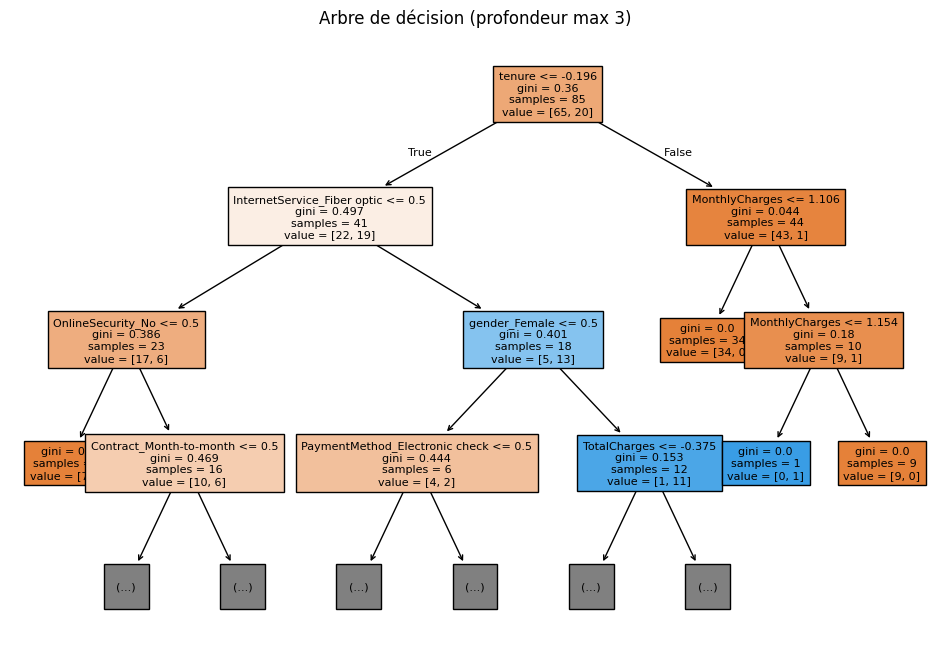

In [ ]:

# Extraire l'étape de preprocessing pour préparer un DataFrame transformé (utile pour l'affichage d'importance)
X_train_trans = preprocessor.fit_transform(X_train)
# Get feature names from the preprocessor (safe method)
ohe = preprocessor.named_transformers_['cat']
cat_names = []
if hasattr(ohe, "get_feature_names_out"):
    cat_names = list(ohe.get_feature_names_out(cat_features))
else:
    # fallback
    for c in cat_features:
        cats = df[c].unique().tolist()
        cat_names += [f"{c}__{v}" for v in cats]

feature_names = num_features + cat_names

# If tree is shallow enough, plot it
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,8))
    tree.plot_tree(pipe_dt.named_steps["clf"], max_depth=3, feature_names=feature_names, filled=True, fontsize=8)
    plt.title("Arbre de décision (profondeur max 3)")
    plt.show()
except Exception as e:
    print("Impossible de tracer l'arbre :", e)
plt.show()
'''
Ce code :

Récupère les noms corrects des colonnes après preprocessing,
Génère une visualisation simplifiée de ton arbre de décision,
Te permet de comprendre visuellement quelles variables l’arbre utilise pour prédire le churn.
'''

## 7) Random Forest (baseline)

In [ ]:

from sklearn.ensemble import RandomForestClassifier
pipe_rf = Pipeline([("pre", preprocessor), ("clf", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))])
pipe_rf.fit(X_train, y_train)
metrics_rf = evaluate_model(pipe_rf, X_test, y_test, prefix="rf_")
metrics_rf
plt.show()

'''
Ce code entraîne un Random Forest sur le DataSet et évalue les tests 
il combine plusieurs arbres et réduit le sur-apprentissage.
'''

              precision    recall  f1-score   support

           0     0.7778    0.8235    0.8000        17
           1     0.2500    0.2000    0.2222         5

    accuracy                         0.6818        22
   macro avg     0.5139    0.5118    0.5111        22
weighted avg     0.6578    0.6818    0.6687        22



## 8) Importance des caractéristiques (Random Forest)

,feature,importance
1,tenure,0.188518
3,TotalCharges,0.115205
2,MonthlyCharges,0.092608
29,Contract_Month-to-month,0.056833
36,PaymentMethod_Electronic check,0.045081
20,OnlineBackup_Yes,0.033920
15,InternetService_Fiber optic,0.028602
18,OnlineSecurity_Yes,0.026038
4,gender_Female,0.024533
17,OnlineSecurity_No,0.023208


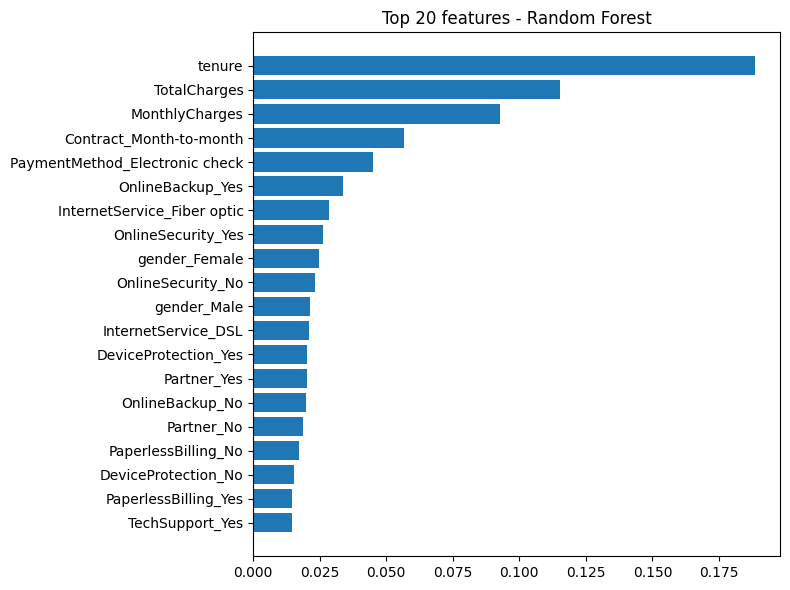

In [ ]:

# Récupérer importances sur features transformées
rf_clf = pipe_rf.named_steps["clf"]
importances = rf_clf.feature_importances_

# feature_names déjà construit : num_features + cat feature names
try:
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False).head(30)
    display(imp_df)
    # Plot top 20
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,6))
    plt.barh(imp_df["feature"].iloc[:20][::-1], imp_df["importance"].iloc[:20][::-1])
    plt.title("Top 20 features - Random Forest")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Erreur lors du calcul des importances :", e)
plt.show()
'''
Ce code sert à identifier les variables les plus influentes dans ton modèle Random Forest et à les afficher dans un tableau + un graphique.
Ça permet d'interpréter le modèle et de répondre à des questions comme :

Quels facteurs expliquent le plus le churn ?

Est-ce plutôt le type de contrat, les services utilisés, ou la facture mensuelle ?
'''

## 9) Optimisation des hyperparamètres — Random Forest

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'clf__n_estimators': [50,100,200],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2,5,10],
    'clf__max_features': ['sqrt','log2', 0.5]
}

rnd = RandomizedSearchCV(pipe_rf, param_distributions=param_dist, n_iter=12, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1)
rnd.fit(X_train, y_train)
print("Best params:", rnd.best_params_)
best_rf = rnd.best_estimator_
metrics_best_rf = evaluate_model(best_rf, X_test, y_test, prefix="best_rf_")
metrics_best_rf
plt.show()

'''
Ce code sert à :

Chercher automatiquement les meilleurs hyperparamètres du Random Forest.
Garder le modèle optimal (best_rf).
Comparer ses performances avec celles des autres modèles
'''

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__n_estimators': 100, 'clf__min_samples_split': 10, 'clf__max_features': 0.5, 'clf__max_depth': 10}
              precision    recall  f1-score   support

           0     0.7895    0.8824    0.8333        17
           1     0.3333    0.2000    0.2500         5

    accuracy                         0.7273        22
   macro avg     0.5614    0.5412    0.5417        22
weighted avg     0.6858    0.7273    0.7008        22



## 10) Optimisation des hyperparamètres — Arbre de décision

In [ ]:

from sklearn.model_selection import GridSearchCV
param_grid = {
    'clf__max_depth': [3,5,7,10, None],
    'clf__min_samples_split': [2,5,10],
    'clf__criterion': ['gini','entropy']
}
grid = GridSearchCV(pipe_dt, param_grid=param_grid, cv=4, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best params (tree):", grid.best_params_)
best_dt = grid.best_estimator_
metrics_best_dt = evaluate_model(best_dt, X_test, y_test, prefix="best_dt_")
metrics_best_dt
plt.show()

'''
Ce code sert à optimiser ton Arbre de Décision via une recherche exhaustive (Grid Search), 
puis à évaluer le meilleur arbre trouvé sur le jeu de test
'''

Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best params (tree): {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_split': 5}
              precision    recall  f1-score   support

           0     0.8000    0.9412    0.8649        17
           1     0.5000    0.2000    0.2857         5

    accuracy                         0.7727        22
   macro avg     0.6500    0.5706    0.5753        22
weighted avg     0.7318    0.7727    0.7332        22



## 11) Comparatif des modèles

In [ ]:

results = {}
results.update({"log": metrics_log})
results.update({"dt": metrics_dt})
results.update({"rf": metrics_rf})
results.update({"best_rf": metrics_best_rf})
results.update({"best_dt": metrics_best_dt})

# Reformat results to DataFrame
rows = []
for k,v in results.items():
    row = {"model": k}
    row.update(v)
    rows.append(row)
res_df = pd.DataFrame(rows).set_index("model").T
res_df
plt.show()

'''
Ce code nous permet de comparer les différentes modèles via un tableau récapitulatif et choisir la meilleure prédiction churn
'''

## 12) Sauvegarde des meilleurs modèles et artefacts

In [ ]:

from joblib import dump
out_dir = Path("./artifacts_models")
out_dir.mkdir(exist_ok=True)
# save preprocessor too (fit inside the best estimator pipelines)
dump(best_rf, out_dir / "best_random_forest_pipeline.joblib")
dump(best_dt, out_dir / "best_decision_tree_pipeline.joblib")
dump(pipe_log, out_dir / "logistic_pipeline.joblib")
print("Modèles sauvegardés dans:", out_dir.resolve())
plt.show()

'''
Ce code permet simplement de stocker//sauvegarder les modèles
'''

Modèles sauvegardés dans: C:\Users\mckll\Desktop\projet3_churn_repo\artifacts_models


13) Différents Modèles

In [ ]:
from pathlib import Path
from joblib import dump

# Crée le dossier artifacts_models s'il n'existe pas
out_dir = Path("./artifacts_models")
out_dir.mkdir(exist_ok=True)

# Sauvegarde uniquement les modèles qui existent
if "best_rf" in globals():
    dump(best_rf, out_dir / "best_random_forest_pipeline.joblib")

if "best_dt" in globals():
    dump(best_dt, out_dir / "best_decision_tree_pipeline.joblib")

if "pipe_log" in globals():
    dump(pipe_log, out_dir / "logistic_pipeline.joblib")

print("Modèles sauvegardés dans :", out_dir.resolve())



Modèles sauvegardés dans : C:\Users\mckll\Desktop\projet3_churn_repo\artifacts_models



---

### Conclusions & recommandations rapides
- L'utilisation du Random Forest est recommandé pour optimiser sa prédiction du churn
- Commencez par utiliser **Random Forest** optimisé (meilleur compromis précision / ROC-AUC).  
- Pour la production, préférez un pipeline scikit-learn complet (préprocessing + modèle) sauvegardé via `joblib`.  
- Sur-échantillonnage (SMOTE) ou calibration des probabilités peuvent améliorer le rappel/précision selon la contrainte business.  
- Monitorer le modèle en production pour dérive de données (drift) — outils recommandés : Evidently, Aporia ou Prometheus + Grafana.
